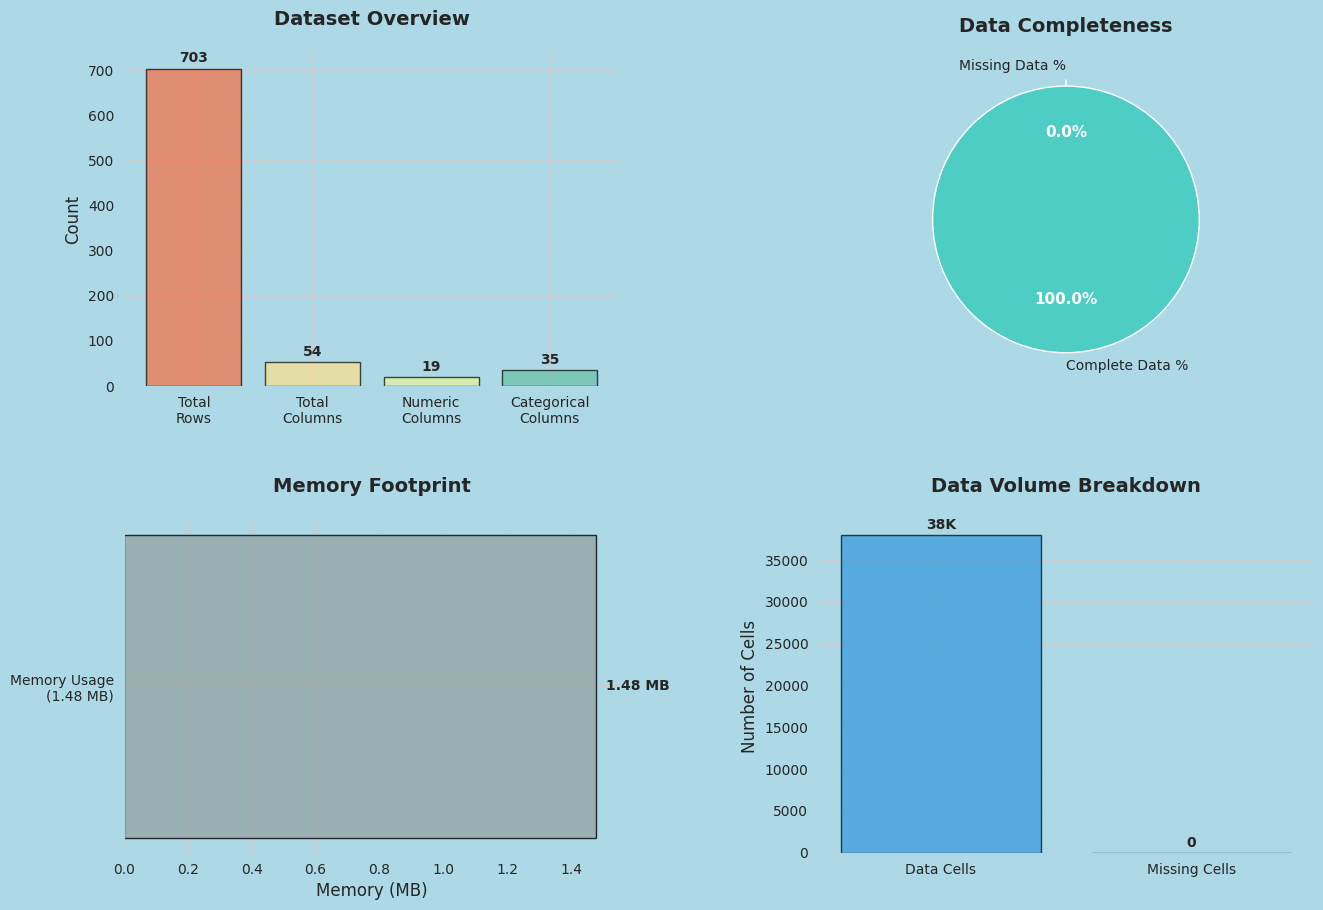

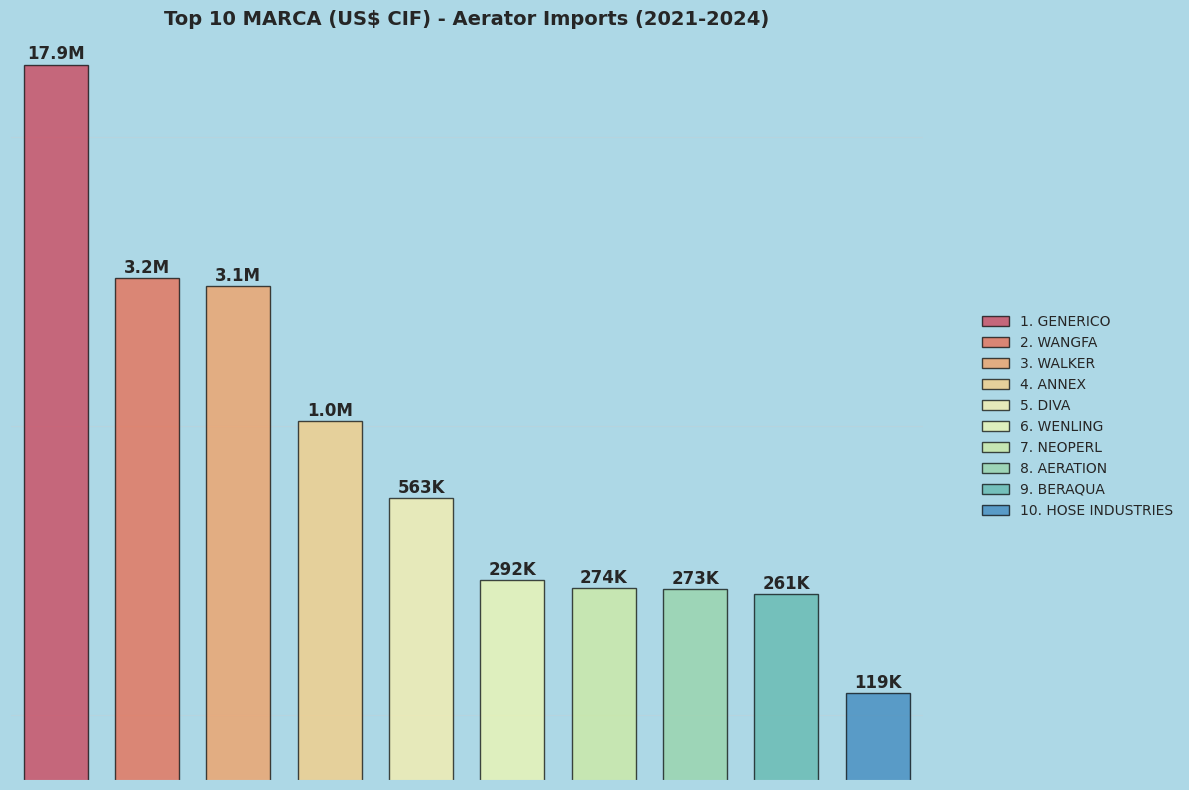

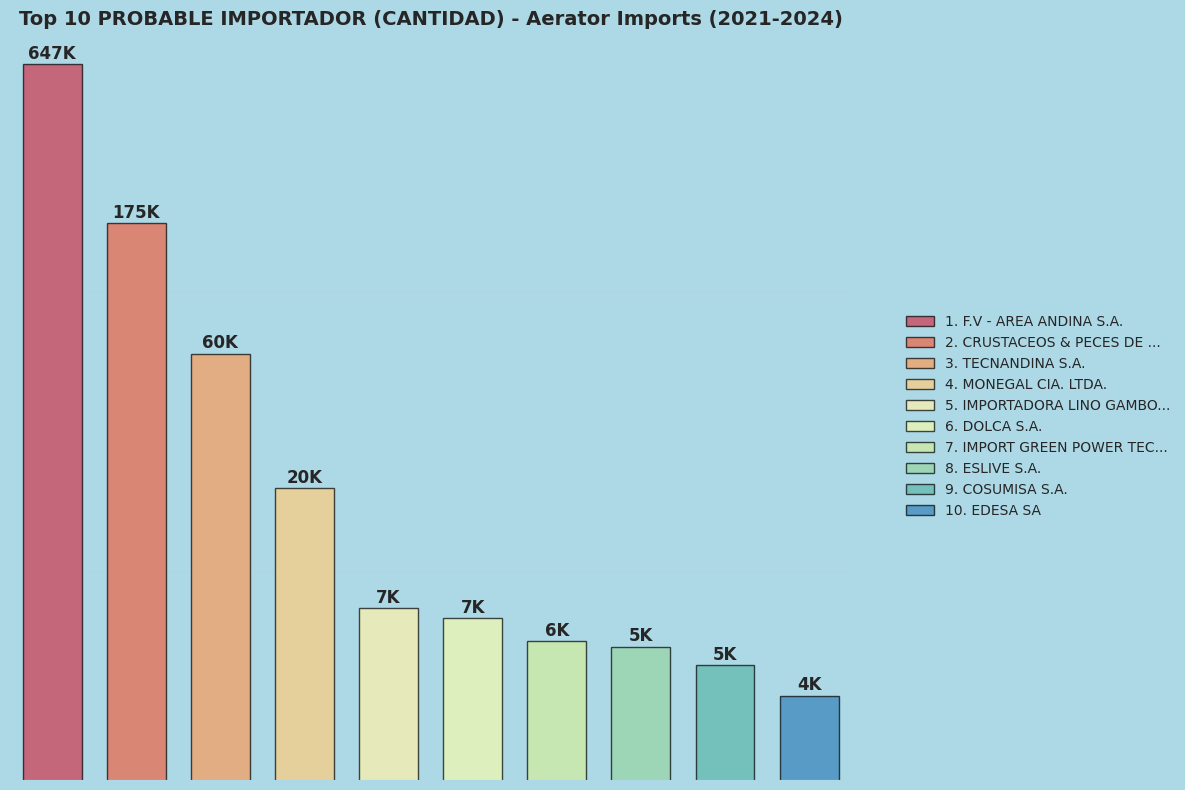

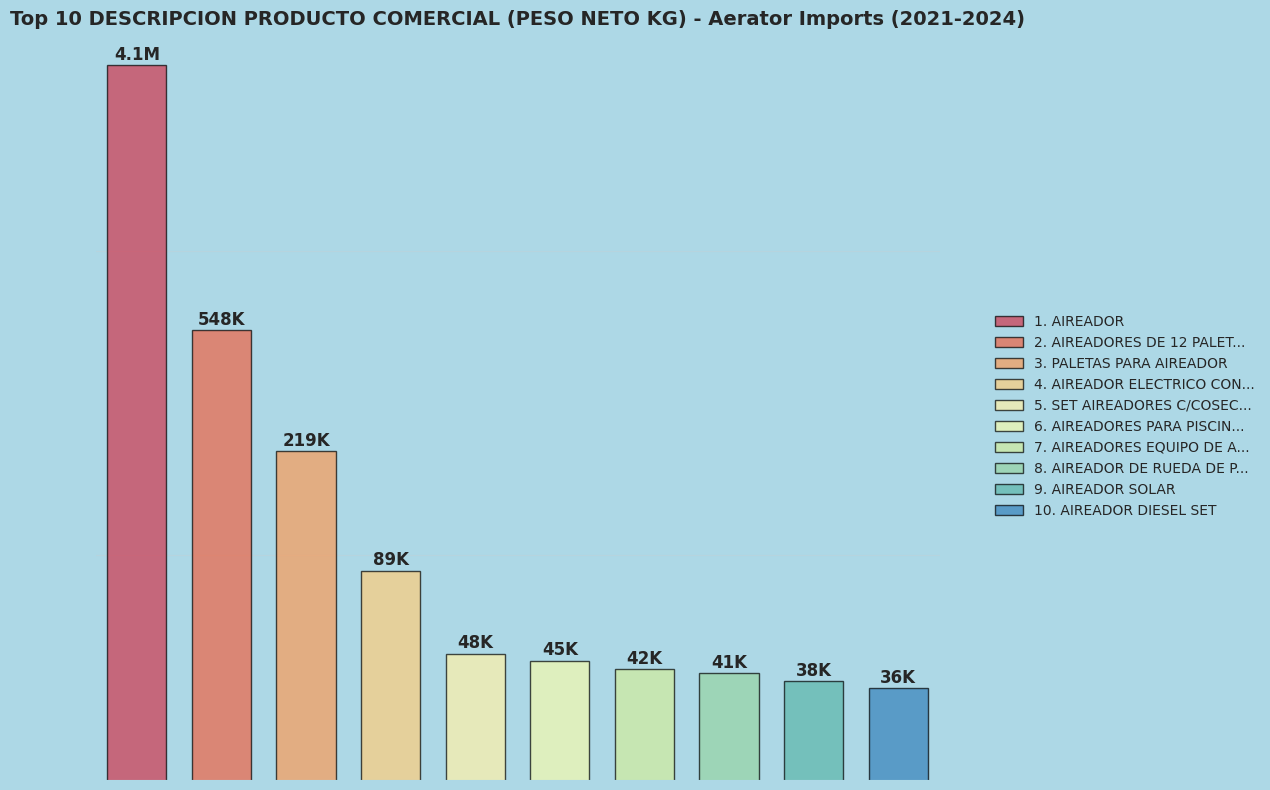

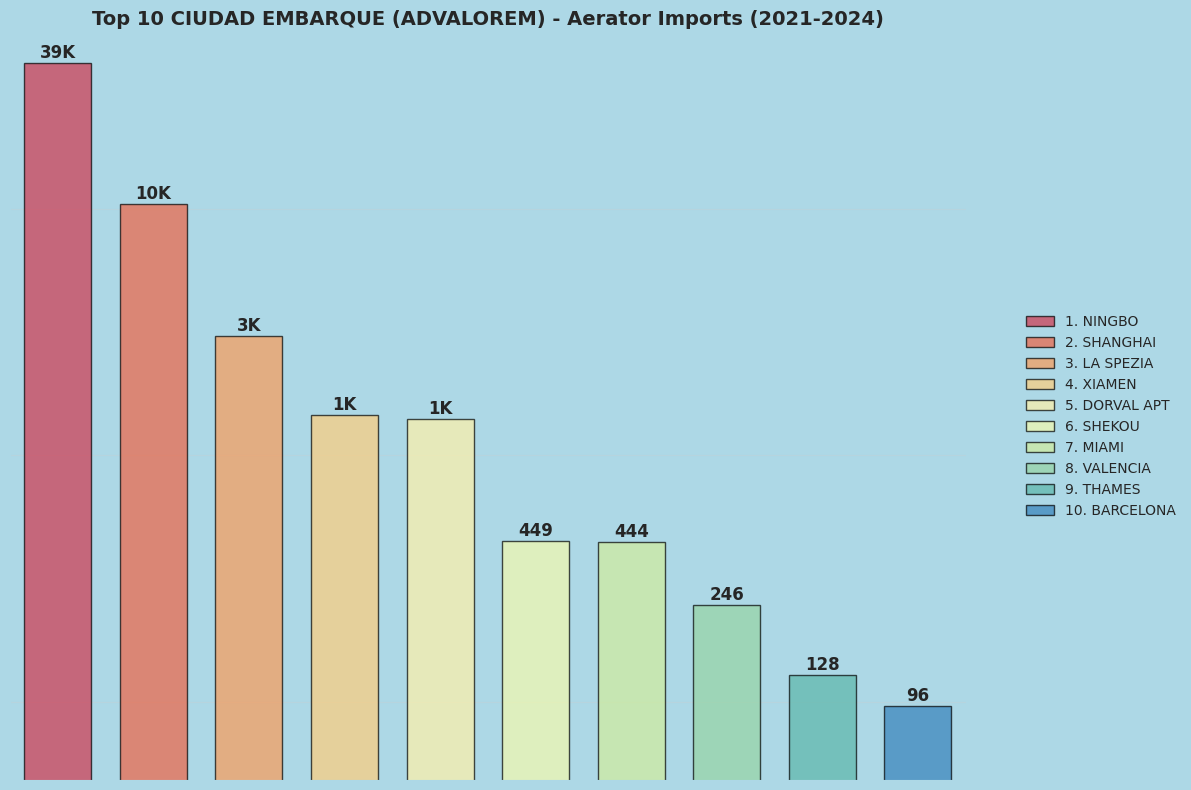

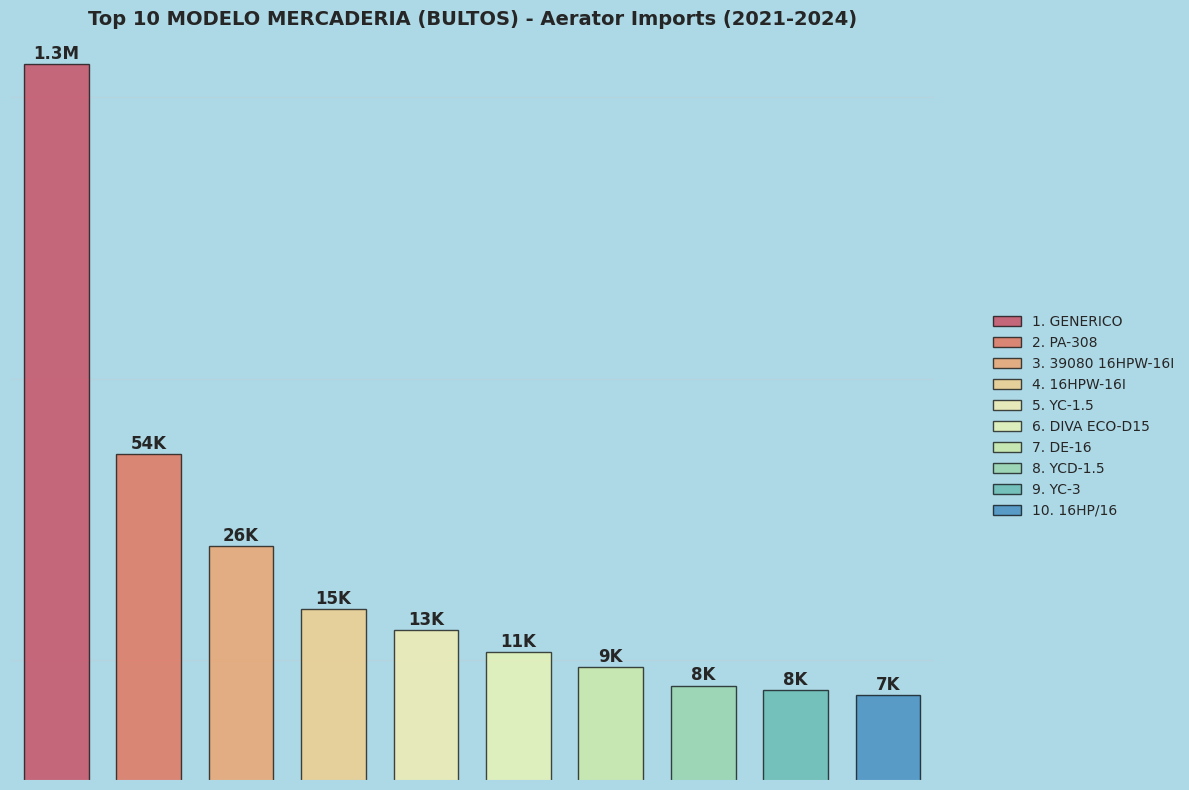

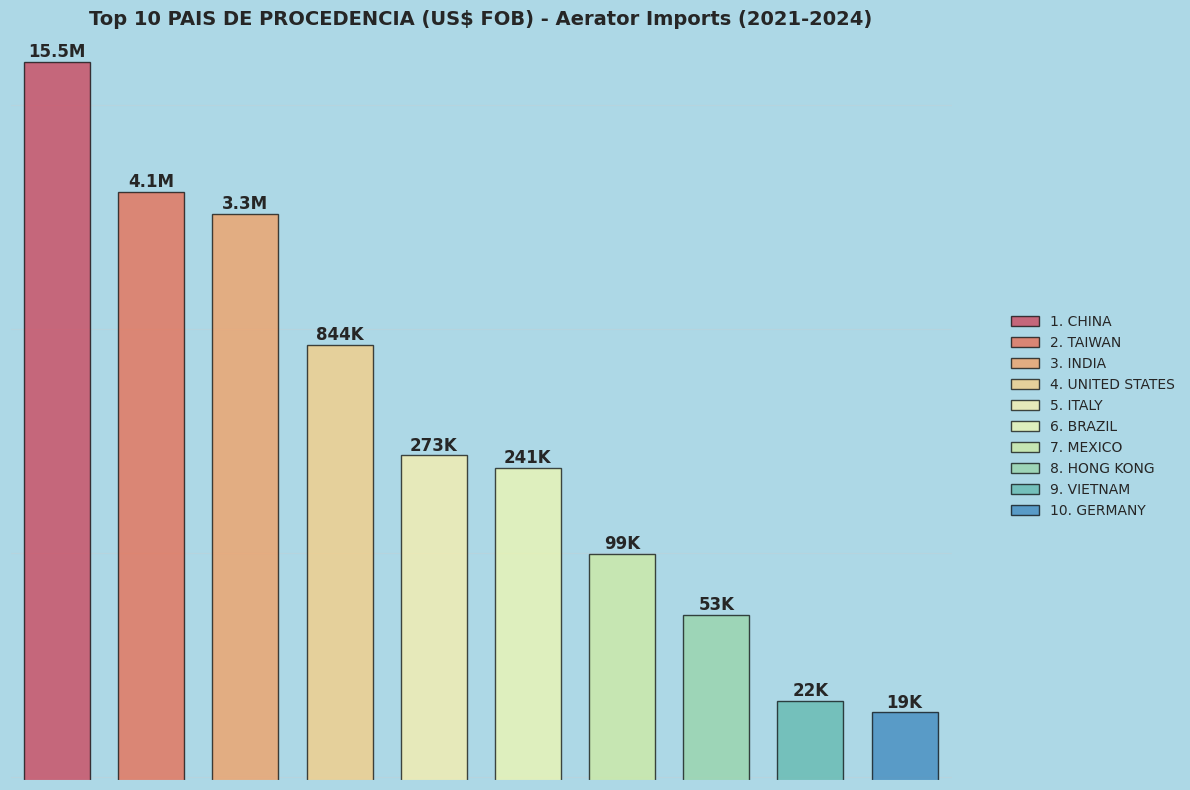

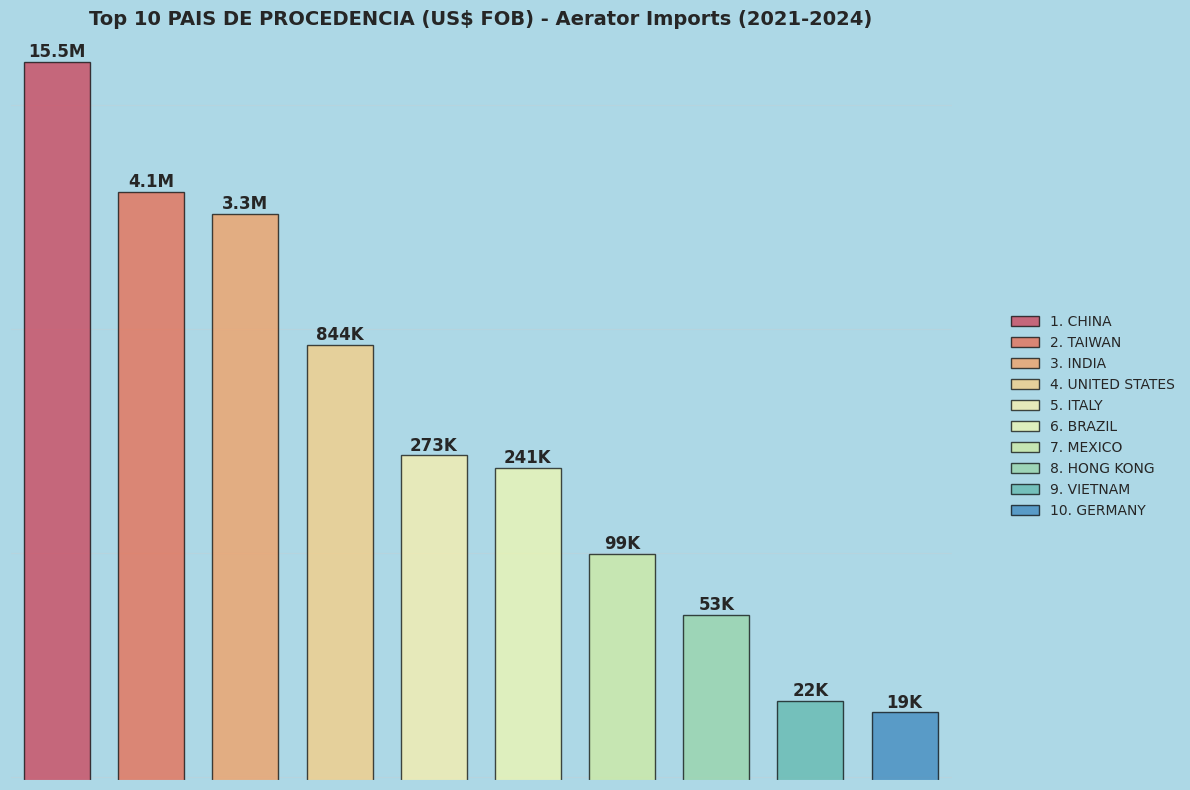

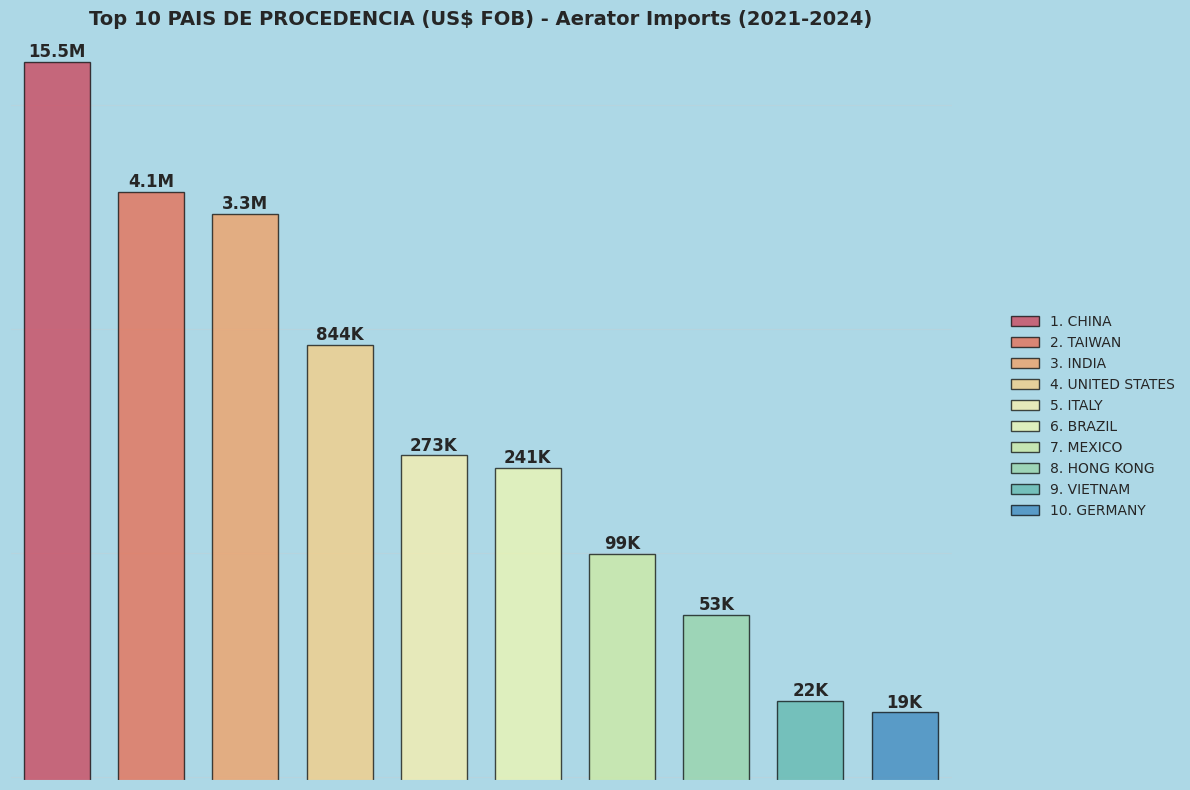

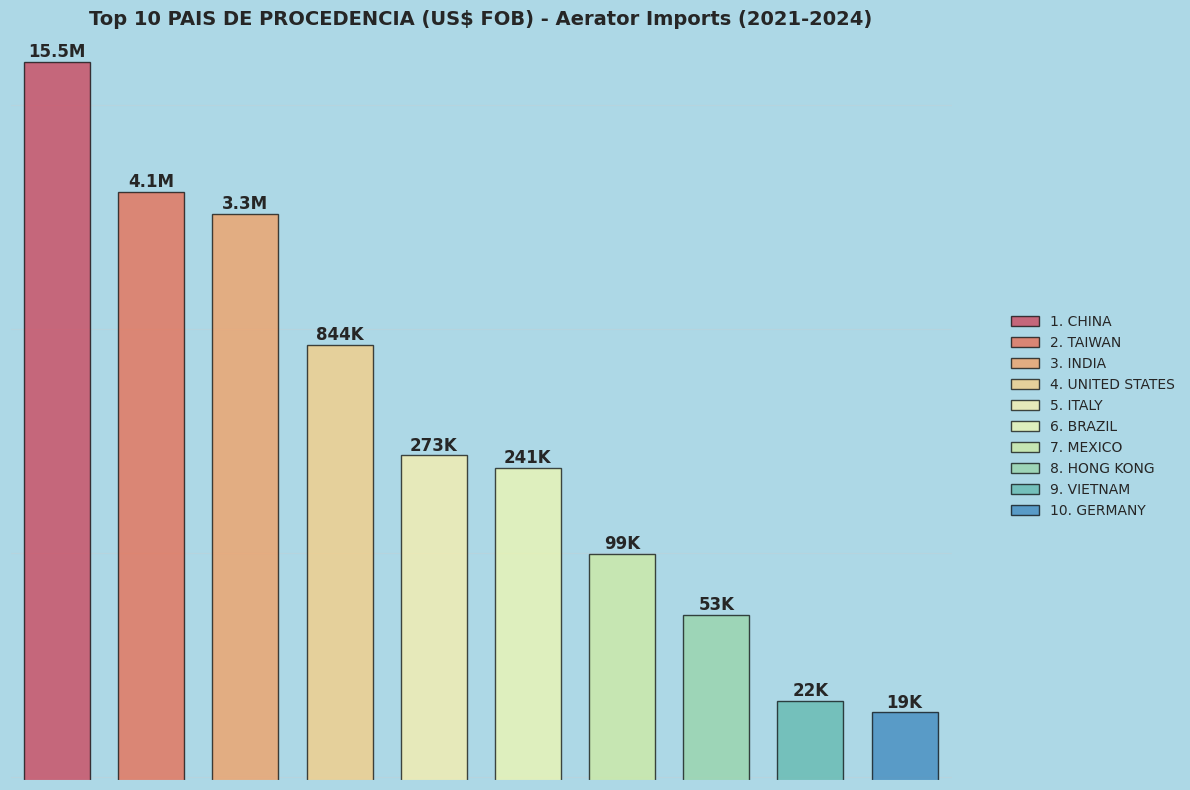

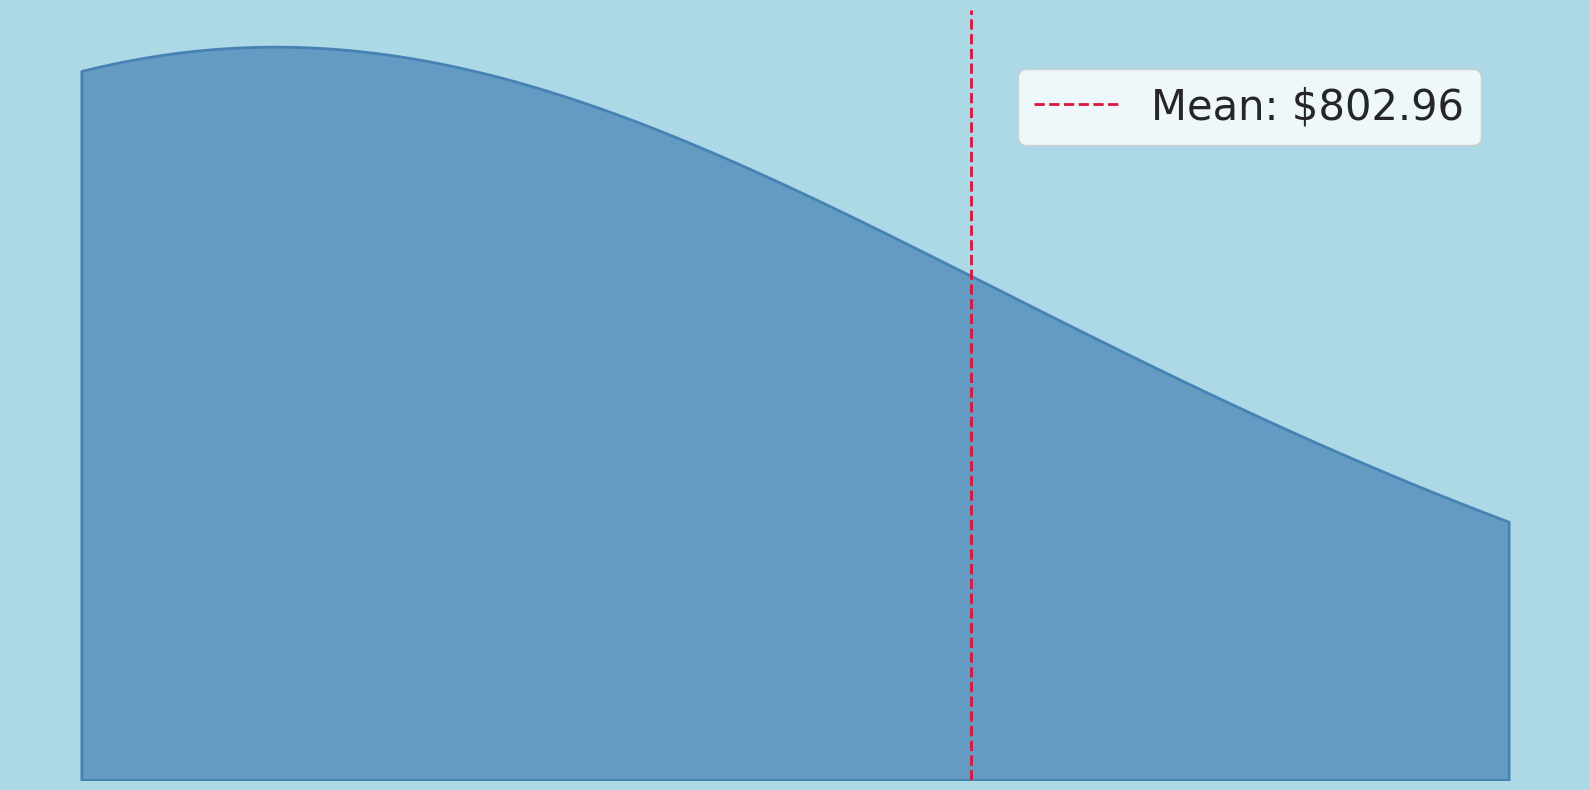

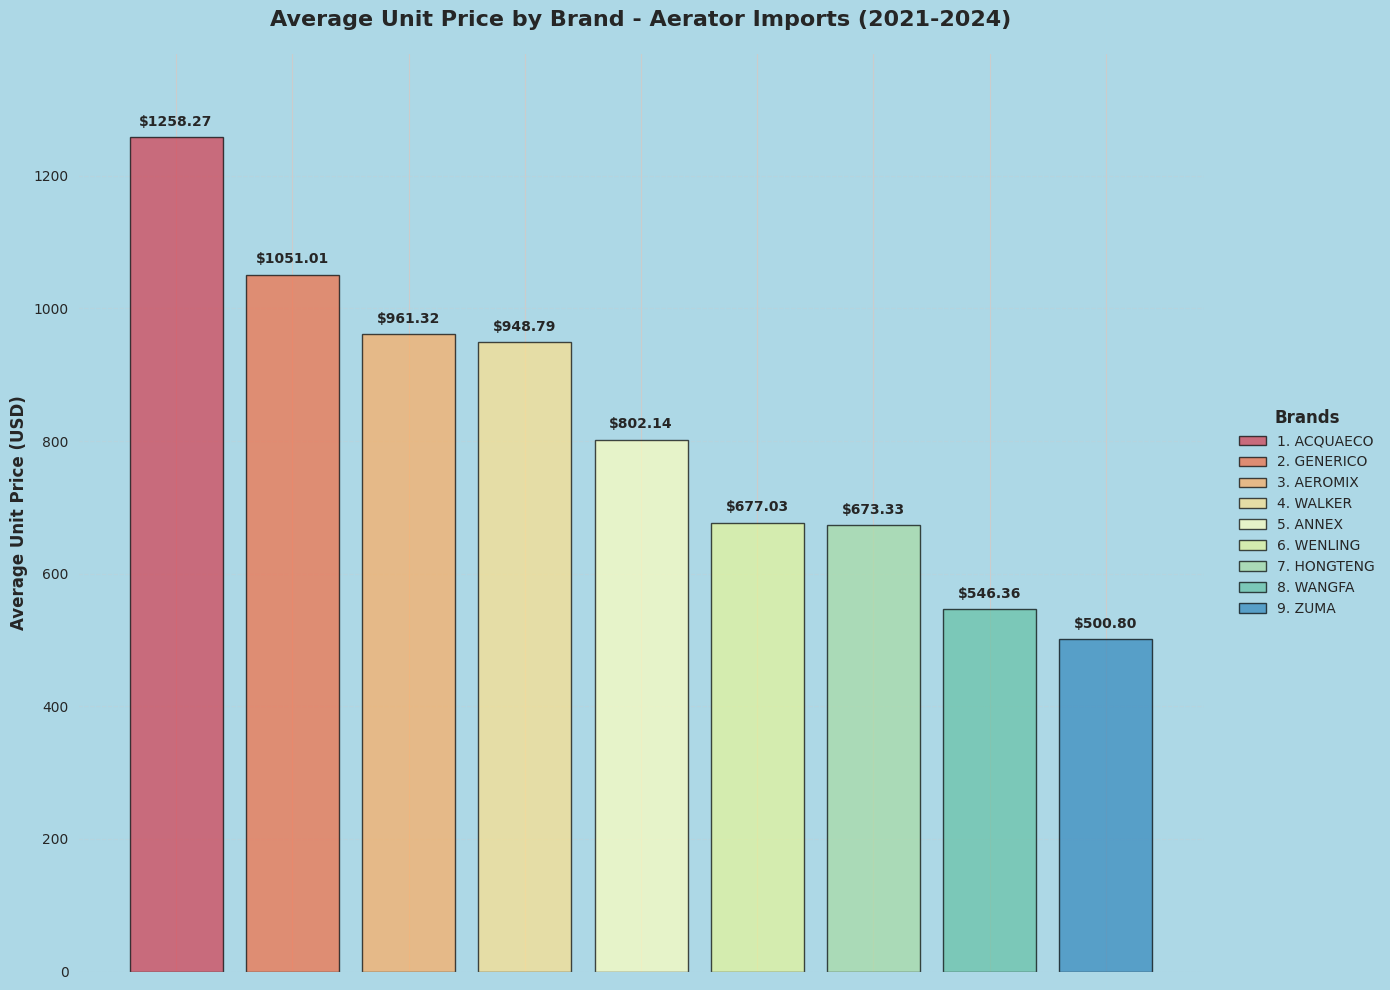

(      RUC IMPORTADOR               AGENCIA DE CARGA  \
 39      992211237001                  FARLETZA S.A.   
 40      992211237001                  FARLETZA S.A.   
 41      992211237001                  FARLETZA S.A.   
 46      704629104001  ZZ OTROS LIBERADORES DIRECTOS   
 124     791774330001             SACO SHIPPING S.A.   
 ...              ...                            ...   
 1635    992847018001  ZZ OTROS LIBERADORES DIRECTOS   
 1636    992847018001  ZZ OTROS LIBERADORES DIRECTOS   
 1658    993374616001            STARCARGO CIA. LTDA   
 1659    993374616001            STARCARGO CIA. LTDA   
 1660    993374616001            STARCARGO CIA. LTDA   
 
                                   EMPRESA DE TRANSPORTE MARCA COMERCIAL  \
 39                 AGENCIA MARITIMA GLOBAL MARGLOBAL SA       HUNG STAR   
 40                 AGENCIA MARITIMA GLOBAL MARGLOBAL SA       HUNG STAR   
 41                 AGENCIA MARITIMA GLOBAL MARGLOBAL SA       HUNG STAR   
 46                   

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from pathlib import Path

from config import (
    INPUT_DIR,
    YEAR_RANGE,
    DATE_COLUMNS,
    COLUMN_TRANSLATIONS,
    BRAND_MAPPING,
    MODEL_MAPPING,
    PRODUCT_MAPPING,
    ANALYSIS_CONFIG,
    VIZ_CONFIG,
)


class DataLoader:
    """Handles loading and initial processing of aerator import data files."""

    def __init__(
        self, input_dir: str = INPUT_DIR, year_range: range = YEAR_RANGE
    ):
        self.input_dir = Path(input_dir)
        self.year_range = year_range
        self.raw_data: Dict[str, pd.DataFrame] = {}

    def load_all_files(self) -> Dict[str, pd.DataFrame]:
        """Load all aerator data files for the specified year range."""
        for year in self.year_range:
            file_name = f"{year}_aerators"
            file_path = self.input_dir / f"{file_name}.csv"

            try:
                df = pd.read_csv(file_path)
                self.raw_data[file_name] = df
            except FileNotFoundError:
                pass
            except Exception as e:
                pass

        return self.raw_data

    def get_common_columns(self) -> List[str]:
        """Find columns present in all datasets."""
        if not self.raw_data:
            raise ValueError("No data loaded. Call load_all_files() first.")

        common_columns = set.intersection(
            *(set(df.columns) for df in self.raw_data.values())
        )
        return list(common_columns)

    def combine_datasets(self) -> pd.DataFrame:
        """Combine all datasets using only common columns."""
        common_columns = self.get_common_columns()

        combined_data = pd.concat(
            [df[common_columns] for df in self.raw_data.values()],
            ignore_index=True,
        )

        return combined_data

    def get_data_summary(self) -> Dict[str, int]:
        """Get summary statistics for loaded data."""
        if not self.raw_data:
            return {}

        total_records = sum(len(df) for df in self.raw_data.values())
        records_by_year = {year: len(df) for year, df in self.raw_data.items()}

        return {
            "total_records": total_records,
            "records_by_year": records_by_year,
            "total_files": len(self.raw_data),
        }


class DataCleaner:
    """Handles data cleaning and preprocessing operations."""

    def __init__(self):
        self.date_columns = DATE_COLUMNS
        self.column_translations = COLUMN_TRANSLATIONS
        self.brand_mapping = BRAND_MAPPING
        self.model_mapping = MODEL_MAPPING
        self.product_mapping = PRODUCT_MAPPING

    def convert_date_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert date columns to datetime format."""
        df_cleaned = df.copy()
        conversion_results = []

        for col in self.date_columns:
            if col in df_cleaned.columns:
                orig_nulls = df_cleaned[col].isnull().sum()
                df_cleaned[col] = pd.to_datetime(
                    df_cleaned[col], errors="coerce"
                )
                new_nulls = df_cleaned[col].isnull().sum()

                conversion_results.append(
                    {
                        "column": col,
                        "orig_nulls": orig_nulls,
                        "new_nulls": new_nulls,
                        "conversion_errors": new_nulls - orig_nulls,
                    }
                )

        return df_cleaned

    def translate_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Translate column names from Spanish to English."""
        df_translated = df.copy()

        # TEMPORARILY DISABLED: Column translation is causing data misalignment
        # The current COLUMN_TRANSLATIONS list doesn't match the actual column order
        # in the combined dataset, causing data to be mapped to wrong columns

        # if len(self.column_translations) == len(df.columns):
        #     df_translated.columns = self.column_translations
        # else:
        #     pass

        return df_translated

    def standardize_categorical_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Standardize brand, model, and product data."""
        df_cleaned = df.copy()

        # Columns to clean (using original Spanish names)
        categorical_columns = {
            "MARCA": self.brand_mapping,  # BRAND
            "MODELO MERCADERIA": self.model_mapping,  # MERCHANDISE MODEL
            "DESCRIPCION PRODUCTO COMERCIAL": self.product_mapping,  # COMMERCIAL PRODUCT DESCRIPTION
            "MARCA COMERCIAL": self.brand_mapping,  # COMMERCIAL BRAND
        }

        for col, mapping in categorical_columns.items():
            if col in df_cleaned.columns:
                # Fill NaN values
                df_cleaned[col] = df_cleaned[col].fillna("GENERICO")

                # Apply mapping
                df_cleaned[col] = df_cleaned[col].replace(mapping)

                # Standardize case
                df_cleaned[col] = df_cleaned[col].astype(str).str.upper()

        return df_cleaned

    def clean_numeric_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and convert numeric columns, handling concatenated or invalid data."""
        df_cleaned = df.copy()

        # Define columns that should be numeric (using original Spanish names)
        numeric_columns = [
            "US$ FOB UNIT",  # Unit price in USD
            "CANTIDAD",  # Quantity
            "US$ FOB",  # Total FOB value
            "PESO NETO KG",  # Net weight
            # Note: Some files might have slightly different column names
        ]

        for col in numeric_columns:
            if col in df_cleaned.columns:
                # Convert to string first to handle any data type issues
                df_cleaned[col] = df_cleaned[col].astype(str)

                # Remove any obvious concatenated or invalid entries
                # Keep only entries that look like valid numbers (digits, dots, commas, minus signs)
                def clean_numeric_value(value):
                    if pd.isna(value) or value in ["nan", "NaN", ""]:
                        return np.nan

                    # Convert to string
                    value_str = str(value).strip()

                    # If it's too long, it's likely concatenated data - mark as invalid
                    if len(value_str) > 20:
                        return np.nan

                    # Remove common non-numeric characters but keep decimal separators
                    import re

                    cleaned = re.sub(r"[^\d.,\-]", "", value_str)

                    # Handle empty strings
                    if not cleaned:
                        return np.nan

                    # Try to convert to float
                    try:
                        # Handle comma as decimal separator (common in some locales)
                        if "," in cleaned and "." not in cleaned:
                            cleaned = cleaned.replace(",", ".")
                        elif "," in cleaned and "." in cleaned:
                            # If both comma and dot, assume comma is thousands separator
                            cleaned = cleaned.replace(",", "")

                        return float(cleaned)
                    except (ValueError, TypeError):
                        return np.nan

                # Apply the cleaning function
                df_cleaned[col] = df_cleaned[col].apply(clean_numeric_value)

                # Convert to numeric, coercing errors to NaN
                df_cleaned[col] = pd.to_numeric(
                    df_cleaned[col], errors="coerce"
                )

        return df_cleaned

    def clean_full_pipeline(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply the complete cleaning pipeline."""
        # Convert dates
        df_cleaned = self.convert_date_columns(df)

        # Translate columns
        df_cleaned = self.translate_columns(df_cleaned)

        # Standardize categorical data
        df_cleaned = self.standardize_categorical_data(df_cleaned)

        # Clean numeric columns
        df_cleaned = self.clean_numeric_columns(df_cleaned)

        return df_cleaned


class DataAnalyzer:
    """Provides data analysis and summary statistics."""

    def __init__(self):
        self.numeric_cols = ANALYSIS_CONFIG["numeric_cols"]
        self.categorical_cols = ANALYSIS_CONFIG["categorical_cols"]
        self.top_n = ANALYSIS_CONFIG["top_n"]

    def get_missing_values_report(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generate a comprehensive missing values report."""
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0].sort_values(
            ascending=False
        )

        missing_percent = (missing_values / len(df) * 100).round(2)

        report = pd.DataFrame(
            {
                "Missing Values": missing_values,
                "Percentage (%)": missing_percent,
            }
        )

        return report

    def get_summary_statistics(self, df: pd.DataFrame) -> Dict[str, float]:
        """Calculate summary statistics for the dataset."""
        numeric_df = df.select_dtypes(include=[np.number])

        stats = {
            "total_rows": len(df),
            "total_columns": len(df.columns),
            "missing_cells": df.isnull().sum().sum(),
            "missing_percentage": (df.isnull().sum().sum() / df.size) * 100,
            "memory_usage_mb": df.memory_usage(deep=True).sum() / (1024**2),
            "numeric_columns": len(numeric_df.columns),
            "categorical_columns": len(df.columns) - len(numeric_df.columns),
        }

        return stats

    def get_top_categories(
        self, df: pd.DataFrame, column: str, n: int = None
    ) -> pd.DataFrame:
        """Get top N categories for a given column."""
        if n is None:
            n = self.top_n

        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in dataframe")

        top_categories = df[column].value_counts().head(n)

        result = pd.DataFrame(
            {
                column.title(): top_categories.index,
                "Count": top_categories.values,
                "Percentage (%)": (
                    top_categories.values / len(df) * 100
                ).round(2),
            }
        )

        return result

    def analyze_price_distribution(
        self, df: pd.DataFrame, price_col: str = "US$ FOB UNIT"
    ) -> Dict[str, float]:
        """Analyze price distribution statistics."""
        if price_col not in df.columns:
            raise ValueError(f"Price column '{price_col}' not found")

        prices = df[price_col].dropna()

        stats = {
            "count": len(prices),
            "mean": prices.mean(),
            "median": prices.median(),
            "std": prices.std(),
            "min": prices.min(),
            "max": prices.max(),
            "q25": prices.quantile(0.25),
            "q75": prices.quantile(0.75),
            "q95": prices.quantile(0.95),
        }

        return stats


class Visualizer:
    """Handles all visualization and plotting operations."""

    def __init__(self):
        self.config = VIZ_CONFIG
        self.numeric_cols = ANALYSIS_CONFIG["numeric_cols"]
        self.categorical_cols = ANALYSIS_CONFIG["categorical_cols"]

        # Set default style
        sns.set_style(self.config["style"])
        plt.rcParams["figure.dpi"] = self.config["dpi"]

    def create_summary_stats_visualization(
        self,
        summary_stats: Dict[str, float],
        figsize: Tuple[int, int] = (14, 10),
    ) -> plt.Figure:
        """Create a comprehensive visualization of summary statistics."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
            2, 2, figsize=figsize, gridspec_kw={"hspace": 0.4, "wspace": 0.4}
        )

        # Apply consistent styling
        for ax in [ax1, ax2, ax3, ax4]:
            self._setup_plot_style(fig, ax)

        # 1. Dataset Overview (top-left)
        overview_data = [
            summary_stats["total_rows"],
            summary_stats["total_columns"],
            summary_stats["numeric_columns"],
            summary_stats["categorical_columns"],
        ]
        overview_labels = [
            "Total\nRows",
            "Total\nColumns",
            "Numeric\nColumns",
            "Categorical\nColumns",
        ]
        colors1 = sns.color_palette(self.config["color_palette"], n_colors=4)

        bars1 = ax1.bar(
            overview_labels,
            overview_data,
            color=colors1,
            alpha=0.7,
            edgecolor="black",
        )
        ax1.set_title(
            "Dataset Overview", fontsize=14, fontweight="bold", pad=20
        )
        ax1.set_ylabel("Count", fontsize=12)

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + max(overview_data) * 0.01,
                f"{int(height):,}",
                ha="center",
                va="bottom",
                fontweight="bold",
            )

        # No need to modify x-axis labels since they're already defined properly
        ax1.tick_params(axis="x", rotation=0)

        # 2. Data Quality Metrics (top-right)
        quality_data = [
            summary_stats["missing_percentage"],
            100 - summary_stats["missing_percentage"],
        ]
        quality_labels = ["Missing Data %", "Complete Data %"]
        colors2 = ["#FF6B6B", "#4ECDC4"]

        wedges, texts, autotexts = ax2.pie(
            quality_data,
            labels=quality_labels,
            colors=colors2,
            autopct="%1.1f%%",
            startangle=90,
            explode=(0.05, 0),
            textprops={"fontsize": 10},
        )
        ax2.set_title(
            "Data Completeness", fontsize=14, fontweight="bold", pad=15
        )

        # Style the pie chart text
        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontweight("bold")
            autotext.set_fontsize(11)

        # 3. Memory Usage (bottom-left)
        memory_mb = summary_stats["memory_usage_mb"]
        total_cells = (
            summary_stats["total_rows"] * summary_stats["total_columns"]
        )
        missing_cells = summary_stats["missing_cells"]
        data_cells = total_cells - missing_cells

        memory_data = [memory_mb]
        memory_labels = [f"Memory Usage\n({memory_mb:.2f} MB)"]

        bars3 = ax3.barh(
            memory_labels,
            memory_data,
            color="#95A5A6",
            alpha=0.8,
            edgecolor="black",
        )
        ax3.set_title(
            "Memory Footprint", fontsize=14, fontweight="bold", pad=20
        )
        ax3.set_xlabel("Memory (MB)", fontsize=12)

        # Add value label
        for bar in bars3:
            width = bar.get_width()
            ax3.text(
                width + memory_mb * 0.02,
                bar.get_y() + bar.get_height() / 2.0,
                f"{width:.2f} MB",
                ha="left",
                va="center",
                fontweight="bold",
            )

        # 4. Data Volume Breakdown (bottom-right)
        volume_data = [data_cells, missing_cells]
        volume_labels = ["Data Cells", "Missing Cells"]
        colors4 = ["#3498DB", "#E74C3C"]

        bars4 = ax4.bar(
            volume_labels,
            volume_data,
            color=colors4,
            alpha=0.7,
            edgecolor="black",
        )
        ax4.set_title(
            "Data Volume Breakdown", fontsize=14, fontweight="bold", pad=20
        )
        ax4.set_ylabel("Number of Cells", fontsize=12)

        # Add value labels with smart formatting
        for bar in bars4:
            height = bar.get_height()
            formatted_height = self._format_large_number(height)
            ax4.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + max(volume_data) * 0.01,
                formatted_height,
                ha="center",
                va="bottom",
                fontweight="bold",
            )

        # Set scientific notation for y-axis if numbers are large
        if max(volume_data) > 1000000:
            ax4.ticklabel_format(
                style="scientific", axis="y", scilimits=(0, 0)
            )

        # Main title
        fig.suptitle(
            "",
            fontsize=16,
            fontweight="bold",
            y=0.95,
        )

        # Use subplots_adjust instead of tight_layout to avoid conflicts with pie chart
        plt.subplots_adjust(top=0.90, bottom=0.1, left=0.1, right=0.95)
        plt.show()

        return fig

    def _format_large_number(self, value: float) -> str:
        """Format large numbers with appropriate suffixes for display."""
        if value > 1000000:
            return f"{value / 1000000:.1f}M"
        elif value > 1000:
            return f"{value / 1000:.0f}K"
        else:
            return f"{value:,.0f}"

    def create_categorical_analysis_plots(
        self, df: pd.DataFrame, figsize: Tuple[int, int] = None
    ) -> List[plt.Figure]:
        """Create dashboard of categorical analysis plots."""
        if figsize is None:
            figsize = self.config["default_figsize"]

        figures = []

        for i, (num_col, cat_col) in enumerate(
            zip(self.numeric_cols, self.categorical_cols)
        ):
            if num_col not in df.columns or cat_col not in df.columns:
                continue

            fig, ax = plt.subplots(1, 1, figsize=figsize)
            self._setup_plot_style(fig, ax)

            # Prepare data
            df_temp = df.copy()
            df_temp[num_col] = pd.to_numeric(df_temp[num_col], errors="coerce")

            grouped_data = (
                df_temp.groupby(cat_col)[num_col]
                .sum()
                .nlargest(10)
                .sort_values(ascending=False)
            )

            if len(grouped_data) == 0 or grouped_data.max() == 0:
                self._plot_no_data(ax, num_col, cat_col)
            else:
                self._create_bar_plot(ax, grouped_data, num_col, cat_col)

            plt.tight_layout()
            figures.append(fig)
            plt.show()

        return figures

    def create_price_distribution_plot(
        self, df: pd.DataFrame, price_col: str = "US$ FOB UNIT"
    ) -> plt.Figure:
        """Create price distribution analysis plot."""
        prices = df[price_col].dropna()

        # Calculate statistics
        mean_price = prices.mean()
        percentile_95 = prices.quantile(0.95)

        # Create figure for price distribution
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        # Price distribution plot
        sns.kdeplot(
            data=prices,
            fill=True,
            color="steelblue",
            alpha=0.7,
            linewidth=2,
            clip=(0, percentile_95),
            bw_adjust=0.5,
            ax=ax,
        )

        # Add mean line
        ax.axvline(
            mean_price,
            color="crimson",
            linestyle="--",
            linewidth=2,
            label=f"Mean: ${mean_price:.2f}",
        )

        self._setup_plot_style(fig, ax)
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])
        ax.set_xlabel("", fontsize=12, fontweight="bold")
        ax.set_ylabel("", fontsize=12, fontweight="bold")
        ax.set_title("")
        ax.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95), fontsize=30)
        ax.grid(axis="x", alpha=0.3, linestyle="--")

        plt.tight_layout()
        plt.show()

        return fig

    def create_brand_price_comparison_plot(
        self, df: pd.DataFrame, price_col: str = "US$ FOB UNIT"
    ) -> plt.Figure:
        """Create brand price comparison plot."""
        # Filter brands for price analysis
        price_range = ANALYSIS_CONFIG["price_filter_range"]
        brand_avg_prices = df.groupby("MARCA")[price_col].mean()
        filtered_brands = brand_avg_prices[
            (brand_avg_prices >= price_range[0])
            & (brand_avg_prices <= price_range[1])
        ].nlargest(10)

        # Create figure for brand comparison
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))

        # Create vertical bar plot
        colors = sns.color_palette(
            self.config["color_palette"], len(filtered_brands)
        )

        bars = ax.bar(
            x=range(len(filtered_brands)),
            height=filtered_brands.values,
            color=colors,
            alpha=0.7,
            edgecolor="black",
            linewidth=1,
        )

        # Add value labels on top of bars
        for i, (bar, value) in enumerate(zip(bars, filtered_brands.values)):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                value + max(filtered_brands) * 0.01,
                f"${value:.2f}",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )

        self._setup_plot_style(fig, ax)

        # Customize axes
        ax.set_xticks(range(len(filtered_brands)))
        ax.set_xticklabels([])  # Hide x-axis labels to use legend instead
        ax.set_ylabel(
            "Average Unit Price (USD)", fontsize=12, fontweight="bold"
        )
        ax.set_title(
            "Average Unit Price by Brand - Aerator Imports (2021-2024)",
            fontsize=16,
            fontweight="bold",
            pad=20,
        )
        ax.grid(axis="y", alpha=0.3, linestyle="--")

        # Set y-axis to start from 0 for better comparison
        ax.set_ylim(0, max(filtered_brands.values) * 1.1)

        # Create legend with brand names
        legend_elements = []
        for i, (brand_name, price) in enumerate(filtered_brands.items()):
            display_name = str(brand_name)
            if len(display_name) > 20:
                display_name = display_name[:17] + "..."
            legend_elements.append(
                plt.Rectangle(
                    (0, 0),
                    1,
                    1,
                    fc=colors[i],
                    alpha=0.7,
                    edgecolor="black",
                    label=f"{i + 1}. {display_name}",
                )
            )

        legend = ax.legend(
            handles=legend_elements,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            ncol=1,
            fontsize=10,
            frameon=False,
            title="Brands",
            title_fontsize=12,
        )

        # Set legend title to bold manually
        legend.get_title().set_fontweight("bold")

        plt.tight_layout()
        plt.show()

        return fig

    def _setup_plot_style(self, fig: plt.Figure, ax: plt.Axes) -> None:
        """Apply consistent styling to plots."""
        fig.patch.set_facecolor(self.config["background_color"])
        ax.set_facecolor(self.config["background_color"])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color(self.config["background_color"])
        ax.spines["bottom"].set_color(self.config["background_color"])

    def _plot_no_data(self, ax: plt.Axes, num_col: str, cat_col: str) -> None:
        """Plot message when no data is available."""
        ax.text(
            0.5,
            0.5,
            f"No data available for {num_col}",
            ha="center",
            va="center",
            transform=ax.transAxes,
            fontsize=14,
        )
        ax.set_title(
            f"Top 10 {cat_col} ({num_col}) - Aerator Imports (2021-2024)",
            fontsize=14,
            fontweight="bold",
            ha="center",
            pad=20,
        )

    def _create_bar_plot(
        self, ax: plt.Axes, grouped_data: pd.Series, num_col: str, cat_col: str
    ) -> None:
        """Create styled bar plot with data."""
        colors = sns.color_palette(
            self.config["color_palette"], n_colors=len(grouped_data)
        )

        bars = sns.barplot(
            x=grouped_data.index,
            y=grouped_data.values,
            ax=ax,
            edgecolor="black",
            alpha=0.7,
            legend=False,
            width=0.7,
        )

        # Set colors manually
        for bar, color in zip(bars.patches, colors):
            bar.set_facecolor(color)

        # Scale handling
        min_value = (
            grouped_data[grouped_data > 0].min()
            if any(grouped_data > 0)
            else 1
        )
        if grouped_data.max() / min_value > 100:
            ax.set_yscale("symlog")
            ax.set_ylim(min_value * 0.5, grouped_data.max() * 1.1)
        else:
            max_val = grouped_data.max()
            if max_val > 0:
                ax.set_ylim(0, max_val * 1.1)

        # Styling
        ax.set_yticklabels([])
        ax.tick_params(axis="both", which="both", length=0)
        ax.set_title(
            f"Top 10 {cat_col} ({num_col}) - Aerator Imports (2021-2024)",
            fontsize=14,
            fontweight="bold",
            ha="center",
            pad=20,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")

        # Add value labels
        for bar in bars.patches:
            height = bar.get_height()
            if height > 0:
                value_text = self._format_value(height)
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height * 1.01,
                    value_text,
                    ha="center",
                    va="bottom",
                    fontsize=12,
                    fontweight="bold",
                )

        # Legend
        plt.setp(ax.get_xticklabels(), visible=False)
        legend_elements = self._create_legend_elements(grouped_data, colors)
        ax.legend(
            handles=legend_elements,
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            ncol=1,
            fontsize=10,
            frameon=False,
        )

        ax.set_xticks(np.arange(len(grouped_data)))
        ax.set_xticklabels(range(1, len(grouped_data) + 1))
        ax.grid(axis="y", linestyle="-", alpha=0.3)

    def _format_value(self, value: float) -> str:
        """Format large numbers with appropriate suffixes."""
        if value > 1000000:
            return f"{value / 1000000:.1f}M"
        elif value > 1000:
            return f"{value / 1000:.0f}K"
        else:
            return f"{value:,.0f}"

    def _create_legend_elements(
        self, grouped_data: pd.Series, colors: List
    ) -> List:
        """Create legend elements for plots."""
        legend_elements = []
        for j, (cat, val) in enumerate(grouped_data.items()):
            if pd.notna(cat):
                display_name = str(cat)
                if len(display_name) > 25:
                    display_name = display_name[:22] + "..."
                legend_elements.append(
                    plt.Rectangle(
                        (0, 0),
                        1,
                        1,
                        fc=colors[j],
                        alpha=0.7,
                        edgecolor="black",
                        label=f"{j + 1}. {display_name}",
                    )
                )
        return legend_elements


class AeratorDataProcessor:
    """Main orchestrator class that coordinates all components."""

    def __init__(self, input_dir: str = INPUT_DIR):
        self.input_dir = input_dir
        self.loader = DataLoader(input_dir)
        self.cleaner = DataCleaner()
        self.analyzer = DataAnalyzer()
        self.visualizer = Visualizer()

        self.raw_data: Optional[Dict[str, pd.DataFrame]] = None
        self.combined_data: Optional[pd.DataFrame] = None
        self.cleaned_data: Optional[pd.DataFrame] = None

    def load_data(self) -> Dict[str, pd.DataFrame]:
        """Load all data files."""
        self.raw_data = self.loader.load_all_files()
        return self.raw_data

    def process_data(self, drop_missing: bool = True) -> pd.DataFrame:
        """Complete data processing pipeline."""
        if self.raw_data is None:
            self.load_data()

        # Combine datasets
        self.combined_data = self.loader.combine_datasets()

        # Clean data
        self.cleaned_data = self.cleaner.clean_full_pipeline(
            self.combined_data
        )

        # Optionally drop rows with missing values
        if drop_missing:
            original_rows = len(self.cleaned_data)
            self.cleaned_data = self.cleaned_data.dropna()
            dropped_rows = original_rows - len(self.cleaned_data)

        return self.cleaned_data

    def analyze_data(self) -> Dict[str, pd.DataFrame]:
        """Perform comprehensive data analysis."""
        if self.cleaned_data is None:
            raise ValueError(
                "No cleaned data available. Run process_data() first."
            )

        results = {
            "summary_stats": self.analyzer.get_summary_statistics(
                self.cleaned_data
            ),
            "missing_values": self.analyzer.get_missing_values_report(
                self.cleaned_data
            ),
            "top_brands": self.analyzer.get_top_categories(
                self.cleaned_data,
                "MARCA",  # BRAND in Spanish
            ),
            "top_models": self.analyzer.get_top_categories(
                self.cleaned_data,
                "MODELO MERCADERIA",  # MERCHANDISE MODEL in Spanish
            ),
            "top_countries": self.analyzer.get_top_categories(
                self.cleaned_data,
                "PAIS DE PROCEDENCIA",  # COUNTRY OF ORIGIN in Spanish
            ),
            "price_stats": self.analyzer.analyze_price_distribution(
                self.cleaned_data
            ),
        }

        return results

    def create_visualizations(self) -> Dict[str, List[plt.Figure]]:
        """Generate all visualizations."""
        if self.cleaned_data is None:
            raise ValueError(
                "No cleaned data available. Run process_data() first."
            )

        # Get summary stats for visualization
        summary_stats = self.analyzer.get_summary_statistics(self.cleaned_data)

        visualizations = {
            "summary_stats": [
                self.visualizer.create_summary_stats_visualization(
                    summary_stats
                )
            ],
            "categorical_plots": self.visualizer.create_categorical_analysis_plots(
                self.cleaned_data
            ),
            "price_distribution": [
                self.visualizer.create_price_distribution_plot(
                    self.cleaned_data
                )
            ],
            "brand_price_comparison": [
                self.visualizer.create_brand_price_comparison_plot(
                    self.cleaned_data
                )
            ],
        }

        return visualizations

    def run_full_analysis(
        self, drop_missing: bool = True
    ) -> Tuple[pd.DataFrame, Dict, Dict]:
        """Run the complete analysis pipeline."""
        # Process data
        cleaned_data = self.process_data(drop_missing=drop_missing)

        # Analyze data
        analysis_results = self.analyze_data()

        # Create visualizations
        visualizations = self.create_visualizations()

        return cleaned_data, analysis_results, visualizations


def main():
    """Demonstration of the modular aerator data analyzer."""
    try:
        # Initialize processor
        processor = AeratorDataProcessor()

        # Run full analysis
        cleaned_data, analysis_results, visualizations = (
            processor.run_full_analysis()
        )

        return cleaned_data, analysis_results, visualizations

    except Exception as e:
        raise e


main()
